# Latent Case Study

We aim to investigate, in depth, a specific component identified as a latent component for a known task (IOI).

In [2]:
%load_ext autoreload
%autoreload 2

import torch
from torch import Tensor
from transformer_lens import HookedTransformer
from transformer_lens.utils import get_device, get_act_name

from attribution_methods import integrated_gradients, activation_patching, highlight_components, asymmetry_score
from testing import Task, TaskDataset, logit_diff_metric, average_correlation, measure_overlap, test_multi_ablated_performance
from plotting import plot_attn, plot_attn_comparison, plot_correlation, plot_correlation_comparison, plot_bar_chart

/vol/bitbucket/mwl21/fypvenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
torch.set_grad_enabled(False)
torch.cuda.empty_cache()

device = get_device()
model = HookedTransformer.from_pretrained("gpt2-small", device=device)

# Explicitly calculate and expose the result for each attention head
model.set_use_attn_result(True)
model.set_use_hook_mlp_in(True)

Loaded pretrained model gpt2-small into HookedTransformer


## Identify latent components in IOI task

In [5]:
clean_input = "When John and Mary went to the store, John gave a bottle of milk to"
corrupted_input = "When John and Mary went to the store, Mary gave a bottle of milk to"
labels = torch.tensor([
    [model.to_tokens("Mary", prepend_bos=False).item(), 
     model.to_tokens("John", prepend_bos=False).item()]
])

clean_tokens = model.to_tokens(clean_input)
corrupted_tokens = model.to_tokens(corrupted_input)

clean_logits, clean_cache = model.run_with_cache(clean_tokens)
clean_logit_diff = logit_diff_metric(clean_logits, labels)
print(f"Clean logit difference: {clean_logit_diff}")

corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens)
corrupted_logit_diff = logit_diff_metric(corrupted_logits, labels)
print(f"Corrupted logit difference: {corrupted_logit_diff}")

Clean logit difference: tensor([3.5417], device='cuda:0')
Corrupted logit difference: tensor([-4.8407], device='cuda:0')


In [174]:
mlp_corrupt_clean = torch.load("results/case_study/mlp_corrupt_clean.pt")
attn_corrupt_clean = torch.load("results/case_study/attn_corrupt_clean.pt")

mlp_clean_corrupt = torch.load("results/case_study/mlp_clean_corrupt.pt")
attn_clean_corrupt = torch.load("results/case_study/attn_clean_corrupt.pt")

latent_attn = torch.load("results/case_study/latent_attn.pt")
latent_mlp = torch.load("results/case_study/latent_mlp.pt")

### Run integrated gradients and save latent components

In [6]:
mlp_corrupt_clean, attn_corrupt_clean = integrated_gradients(model, clean_tokens, clean_cache, corrupted_cache, logit_diff_metric, labels)
torch.save(mlp_corrupt_clean, "results/case_study/mlp_corrupt_clean.pt")
torch.save(attn_corrupt_clean, "results/case_study/attn_corrupt_clean.pt")

mlp_clean_corrupt, attn_clean_corrupt = integrated_gradients(model, corrupted_tokens, corrupted_cache, clean_cache, logit_diff_metric, labels)
torch.save(mlp_clean_corrupt, "results/case_study/mlp_clean_corrupt.pt")
torch.save(attn_clean_corrupt, "results/case_study/attn_clean_corrupt.pt")


Error (delta) for blocks.0.attn.hook_result attribution: tensor([1.6689e-06], device='cuda:0')

Error (delta) for blocks.0.mlp.hook_post attribution: tensor([8.5831e-06], device='cuda:0')

Error (delta) for blocks.1.attn.hook_result attribution: tensor([6.5267e-06], device='cuda:0')

Error (delta) for blocks.1.mlp.hook_post attribution: tensor([-8.2254e-06], device='cuda:0')

Error (delta) for blocks.2.attn.hook_result attribution: tensor([6.2883e-06], device='cuda:0')

Error (delta) for blocks.2.mlp.hook_post attribution: tensor([6.7651e-06], device='cuda:0')

Error (delta) for blocks.3.attn.hook_result attribution: tensor([4.7684e-06], device='cuda:0')

Error (delta) for blocks.3.mlp.hook_post attribution: tensor([4.4107e-06], device='cuda:0')

Error (delta) for blocks.4.attn.hook_result attribution: tensor([9.4175e-06], device='cuda:0')

Error (delta) for blocks.4.mlp.hook_post attribution: tensor([7.1377e-06], device='cuda:0')

Error (delta) for blocks.5.attn.hook_result attributi

In [17]:
mlp_asymmetry = asymmetry_score(mlp_corrupt_clean, mlp_clean_corrupt, is_ig=True)
attn_asymmetry = asymmetry_score(attn_corrupt_clean, attn_clean_corrupt, is_ig=True)

latent_attn = highlight_components(attn_corrupt_clean)[0] ^ highlight_components(attn_clean_corrupt)[0]
latent_attn_indices = latent_attn.nonzero()
latent_mlp = highlight_components(mlp_corrupt_clean)[0] ^ highlight_components(mlp_clean_corrupt)[0]
latent_mlp_indices = latent_mlp.nonzero()

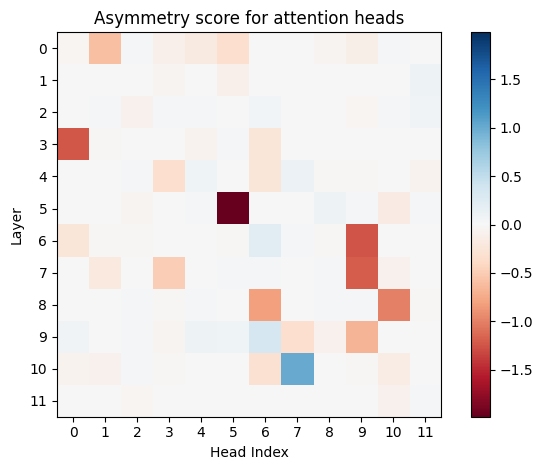

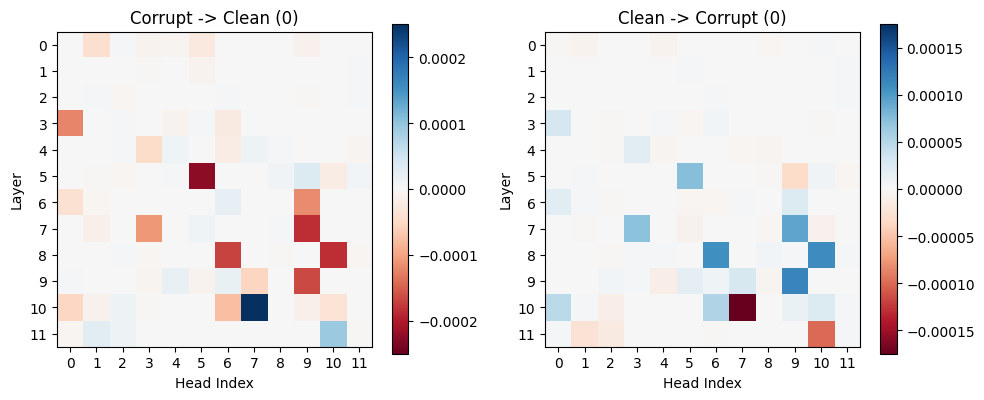

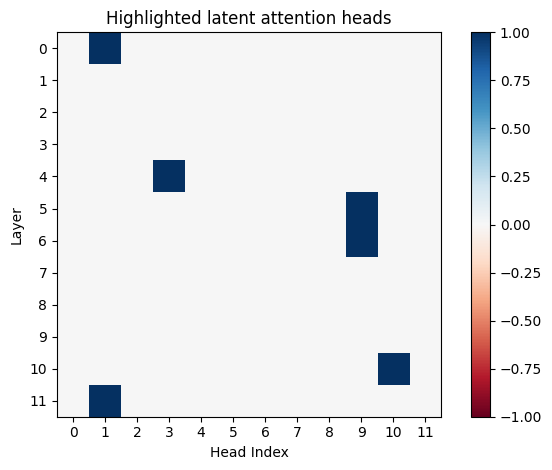

In [18]:
# Visualise latent components

plot_attn(attn_asymmetry[0], model, title="Asymmetry score for attention heads")
plot_attn_comparison(attn_corrupt_clean, attn_clean_corrupt, model, "Corrupt -> Clean", "Clean -> Corrupt")
plot_attn(latent_attn[0].int(), model, title="Highlighted latent attention heads")

In [19]:
torch.save(latent_attn, "results/case_study/latent_attn.pt")
torch.save(latent_mlp, "results/case_study/latent_mlp.pt")

## Attributions under knock out

After ablating the most significant components identified in the IOI circuit, we examine the attribution scores of the remaining components, particularly the latent components.

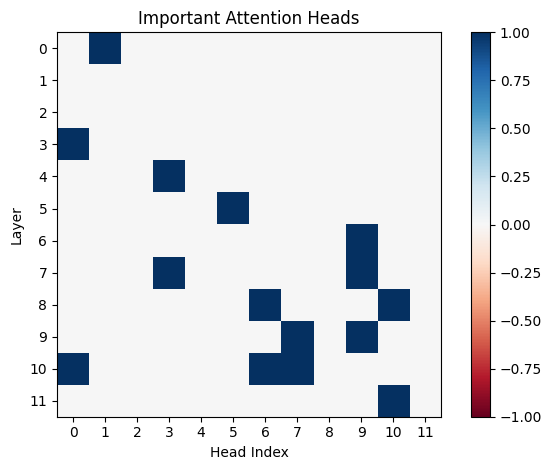

In [20]:
attn_important, attn_important_indices = highlight_components(attn_corrupt_clean, percentile=0.9)
mlp_important, mlp_important_indices = highlight_components(mlp_corrupt_clean, percentile=0.9)

plot_attn(attn_important[0].int(), model, title="Important Attention Heads")

In [21]:
# Ablate all important components using corrupted activations
model.reset_hooks(including_permanent=True)

for _, layer, idx in attn_important_indices:
    def ablate_hook(act, hook, idx=idx):
        act[:, :, idx] = corrupted_cache[hook.name][:, :, idx]
        return act
    layer_name = get_act_name("result", layer)
    model.add_perma_hook(layer_name, ablate_hook)

for _, layer, idx in mlp_important_indices:
    def ablate_hook(act, hook, idx=idx):
        act[:, :, idx] = corrupted_cache[hook.name][:, :, idx]
        return act
    layer_name = get_act_name("post", layer)
    model.add_perma_hook(layer_name, ablate_hook)

In [25]:
mlp_corrupt_clean_knockout, attn_corrupt_clean_knockout = integrated_gradients(model, clean_tokens, clean_cache, corrupted_cache, logit_diff_metric, labels)

torch.save(mlp_corrupt_clean_knockout, "results/case_study/mlp_corrupt_clean_knockout.pt")
torch.save(attn_corrupt_clean_knockout, "results/case_study/attn_corrupt_clean_knockout.pt")


Error (delta) for blocks.0.attn.hook_result attribution: tensor([1.0688e-05], device='cuda:0')

Error (delta) for blocks.0.mlp.hook_post attribution: tensor([1.8328e-06], device='cuda:0')

Error (delta) for blocks.1.attn.hook_result attribution: tensor([1.2837e-05], device='cuda:0')

Error (delta) for blocks.1.mlp.hook_post attribution: tensor([8.0429e-06], device='cuda:0')

Error (delta) for blocks.2.attn.hook_result attribution: tensor([-3.2112e-06], device='cuda:0')

Error (delta) for blocks.2.mlp.hook_post attribution: tensor([1.1176e-05], device='cuda:0')

Error (delta) for blocks.3.attn.hook_result attribution: tensor([3.2149e-06], device='cuda:0')

Error (delta) for blocks.3.mlp.hook_post attribution: tensor([-9.0264e-06], device='cuda:0')

Error (delta) for blocks.4.attn.hook_result attribution: tensor([2.4363e-06], device='cuda:0')

Error (delta) for blocks.4.mlp.hook_post attribution: tensor([-4.3400e-06], device='cuda:0')

Error (delta) for blocks.5.attn.hook_result attribu

### Analysis

In [23]:
mlp_corrupt_clean_knockout = torch.load("results/case_study/mlp_corrupt_clean_knockout.pt")
attn_corrupt_clean_knockout = torch.load("results/case_study/attn_corrupt_clean_knockout.pt")

In [26]:
# Sanity check: attribution scores should be zero at ablated components
for sample, layer, idx in attn_important_indices:
    assert attn_corrupt_clean_knockout[sample, layer, idx] == 0

for sample, layer, idx in mlp_important_indices:
    assert mlp_corrupt_clean_knockout[sample, layer, idx] == 0

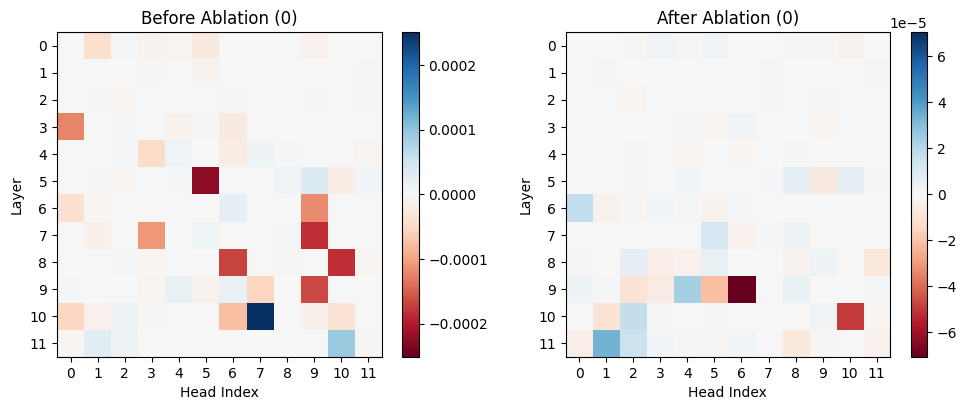

In [27]:
plot_attn_comparison(attn_corrupt_clean, attn_corrupt_clean_knockout, model, "Before Ablation", "After Ablation")

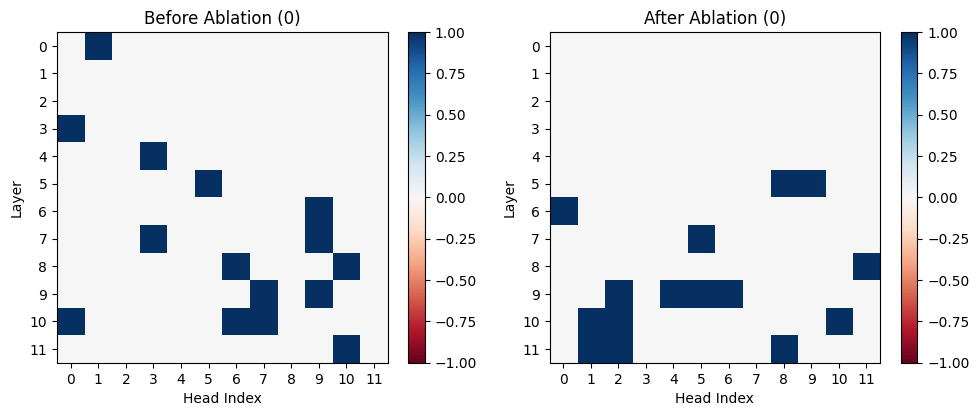

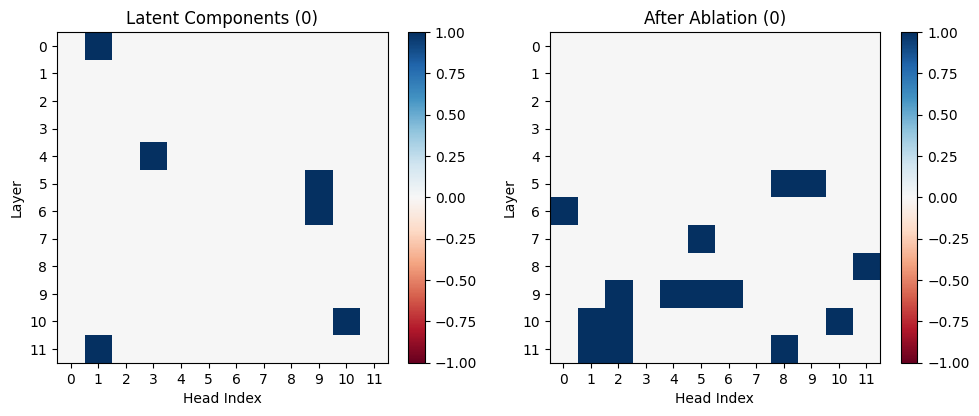

In [28]:
post_knockout_attn, post_knockout_attn_indices = highlight_components(attn_corrupt_clean_knockout)
post_knockout_mlp, post_knockout_mlp_indices = highlight_components(mlp_corrupt_clean_knockout)

plot_attn_comparison(attn_important.int(), post_knockout_attn.int(), model, "Before Ablation", "After Ablation")
plot_attn_comparison(latent_attn.int(), post_knockout_attn.int(), model, "Latent Components", "After Ablation")

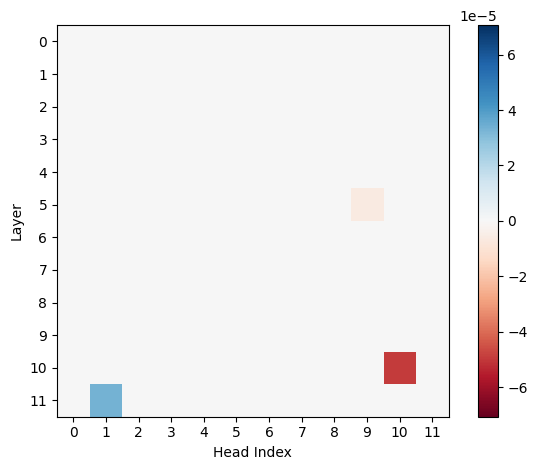

In [29]:
# Get new attribution scores for latent components
plot_attn(attn_corrupt_clean_knockout[0] * latent_attn[0], model, attn_corrupt_clean_knockout.abs().max())

In [30]:
knockout_latent_attn_overlap = measure_overlap(post_knockout_attn, latent_attn)
print(f"Overlap between latent attention and post-knockout attention: {knockout_latent_attn_overlap.item()}")

knockout_latent_mlp_overlap = measure_overlap(post_knockout_mlp, latent_mlp)
print(f"Overlap between latent MLP and post-knockout MLP: {knockout_latent_mlp_overlap.item()}")

Overlap between latent attention and post-knockout attention: 0.1666666716337204
Overlap between latent MLP and post-knockout MLP: 0.16938164830207825


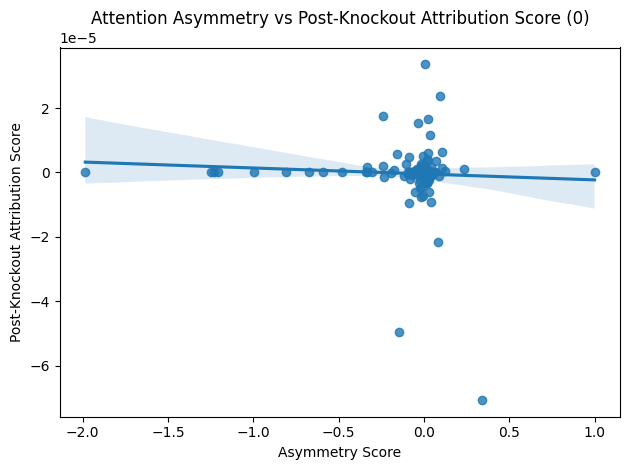

Correlation coefficient: -0.06162399310923598


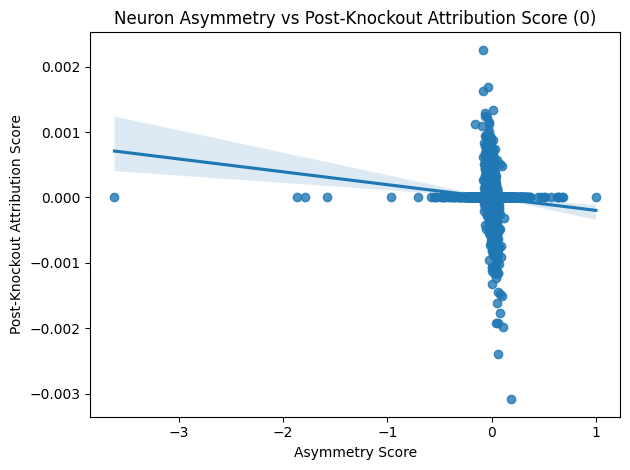

Correlation coefficient: -0.07283144516007434


In [31]:
# Plot correlation between asymmetry and post-knockout scores
plot_correlation(attn_asymmetry, attn_corrupt_clean_knockout, "Asymmetry Score", "Post-Knockout Attribution Score", "Attention Asymmetry vs Post-Knockout Attribution Score")
plot_correlation(mlp_asymmetry, mlp_corrupt_clean_knockout, "Asymmetry Score", "Post-Knockout Attribution Score", "Neuron Asymmetry vs Post-Knockout Attribution Score")

Conclusion: latent components detected using opposite patching directions, do not correspond to components with high attribution scores after knockout of primary circuit components.

## Pairwise ablation of attention heads

We pick the latent component (6, 9), which has the highest difference in attribution scores, and ablate it alongside every significant component and latent component. For each ablated pair, we measure the logit difference to quantify the total effect on the model's output.

In [32]:
# Reset model
device = get_device()
model = HookedTransformer.from_pretrained("gpt2-small", device=device)

# Explicitly calculate and expose the result for each attention head
model.set_use_attn_result(True)
model.set_use_hook_mlp_in(True)

target_layer, target_head = 6, 9

Loaded pretrained model gpt2-small into HookedTransformer


In [33]:
model.reset_hooks(including_permanent=True)

target_hook_name = get_act_name("result", target_layer)
def ablate_target_head_hook(act, hook):
    act[:, :, target_head] = corrupted_cache[hook.name][:, :, target_head]
    return act
model.add_perma_hook(target_hook_name, ablate_target_head_hook)

In [34]:
# Ablate every component in the model alongside (6, 9)

_, attn_pairwise_ablation = activation_patching(model, clean_tokens, clean_logit_diff, corrupted_cache, corrupted_logit_diff, logit_diff_metric, labels)

Activation patching on attention heads in layer 0
Activation patching on MLP in layer 0
Activation patching on attention heads in layer 1
Activation patching on MLP in layer 1
Activation patching on attention heads in layer 2
Activation patching on MLP in layer 2
Activation patching on attention heads in layer 3
Activation patching on MLP in layer 3
Activation patching on attention heads in layer 4
Activation patching on MLP in layer 4
Activation patching on attention heads in layer 5
Activation patching on MLP in layer 5
Activation patching on attention heads in layer 6
Activation patching on MLP in layer 6
Activation patching on attention heads in layer 7
Activation patching on MLP in layer 7
Activation patching on attention heads in layer 8
Activation patching on MLP in layer 8
Activation patching on attention heads in layer 9
Activation patching on MLP in layer 9
Activation patching on attention heads in layer 10
Activation patching on MLP in layer 10
Activation patching on attenti

In [35]:
torch.save(attn_pairwise_ablation, "results/case_study/attn_pairwise_ablation.pt")

### Analysis

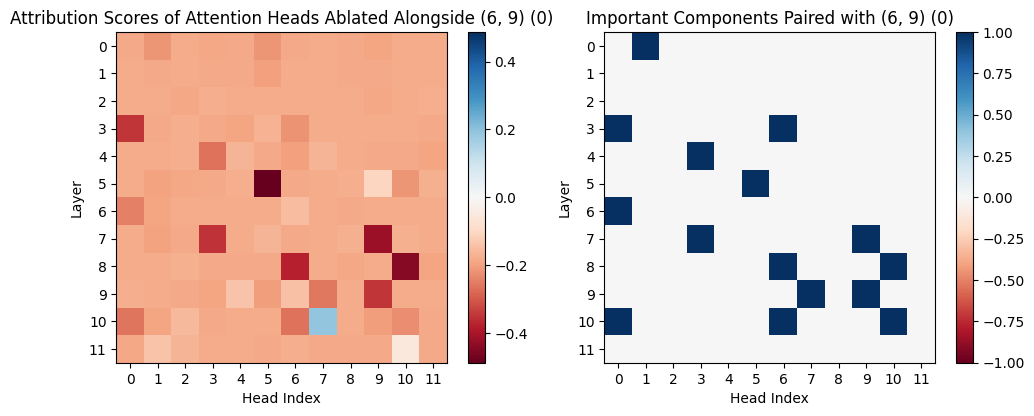

In [36]:
# Identify pairs of ablated components which have high scores
attn_pairwise_ablation_important, attn_pairwise_ablation_important_indices = highlight_components(attn_pairwise_ablation, percentile=0.9)

# Visualise the effect on output when each component is ablated alongside (6, 9)
plot_attn_comparison(attn_pairwise_ablation, attn_pairwise_ablation_important.int(), model, "Attribution Scores of Attention Heads Ablated Alongside (6, 9)", "Important Components Paired with (6, 9)")

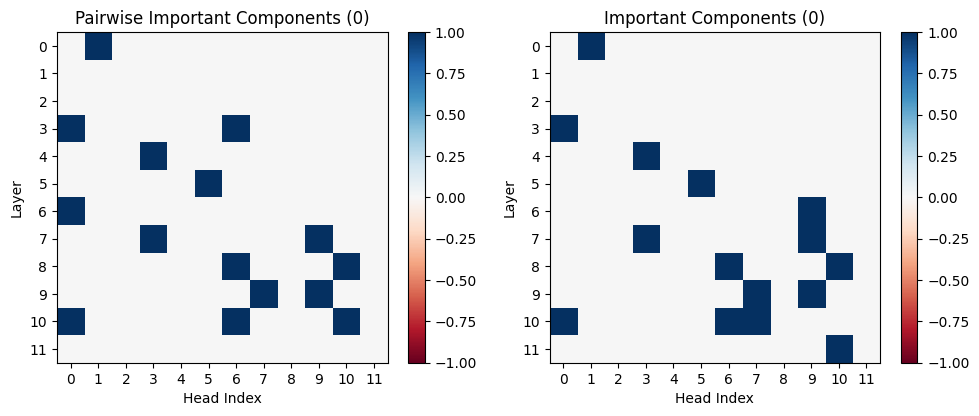

Overlap between pairwise ablation and important components: 0.6666666865348816


In [37]:
# Measure overlap between pairwise ablation components and important components
plot_attn_comparison(attn_pairwise_ablation_important.int(), attn_important.int(), model, "Pairwise Important Components", "Important Components")
print(f"Overlap between pairwise ablation and important components: {measure_overlap(attn_pairwise_ablation_important, attn_important).item()}")

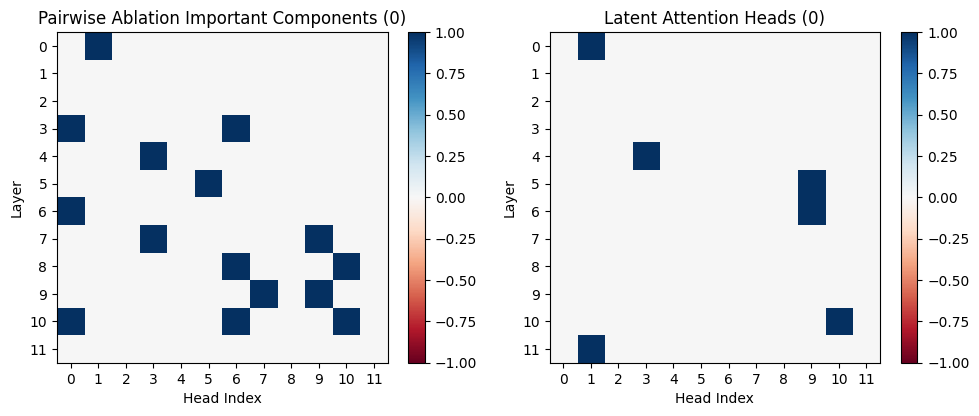

Overlap between pairwise ablation and latent attention: 0.1666666716337204


In [38]:
# Measure overlap between pairwise ablation components and latent components
plot_attn_comparison(attn_pairwise_ablation_important.int(), latent_attn.int(), model, "Pairwise Ablation Important Components", "Latent Attention Heads")
print(f"Overlap between pairwise ablation and latent attention: {measure_overlap(attn_pairwise_ablation_important, latent_attn).item()}")

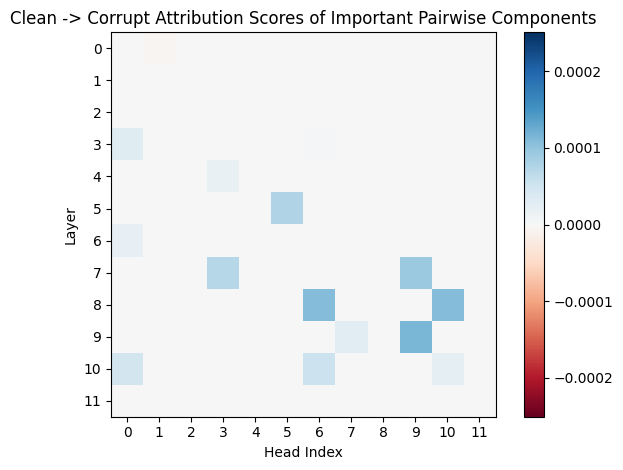

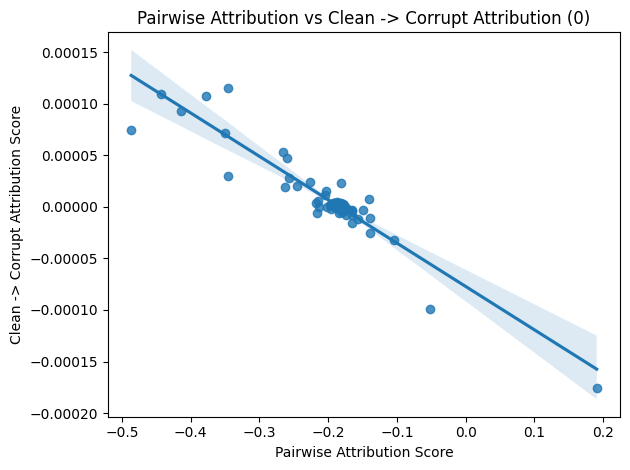

Correlation coefficient: -0.9375457190256217


In [39]:
# Check if pair of ablated attention heads have high attribution scores when patching in the opposite direction.

plot_attn(
    attn_pairwise_ablation_important[0] * attn_clean_corrupt[0], 
    model, 
    bound=attn_corrupt_clean.abs().max(), 
    title="Clean -> Corrupt Attribution Scores of Important Pairwise Components")

plot_correlation(
    attn_pairwise_ablation, 
    attn_clean_corrupt, 
    "Pairwise Attribution Score", 
    "Clean -> Corrupt Attribution Score", 
    "Pairwise Attribution vs Clean -> Corrupt Attribution")

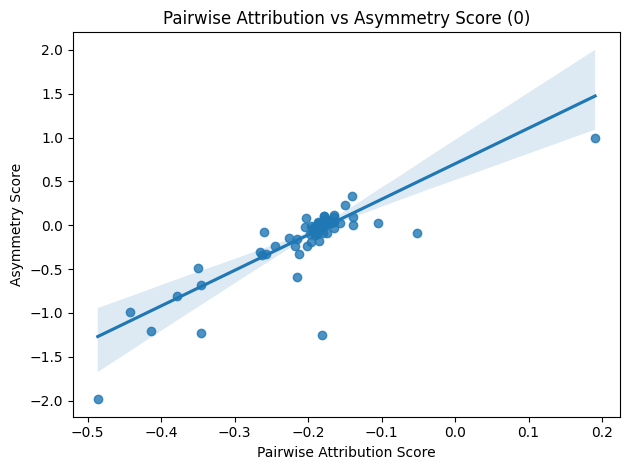

Correlation coefficient: 0.8376418303375892


In [40]:
# Compare correlation between pairwise ablation (joint components) and asymmetry scores (latent components).
plot_correlation(
    attn_pairwise_ablation, 
    attn_asymmetry, 
    "Pairwise Attribution Score", 
    "Asymmetry Score", 
    "Pairwise Attribution vs Asymmetry Score")

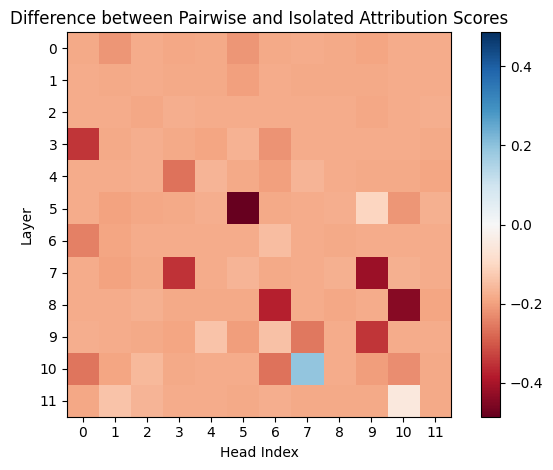

In [41]:
# Compare pairwise ablation scores with isolated ablation scores.
pairwise_isolated_ablation_diff = (attn_pairwise_ablation - attn_corrupt_clean)
plot_attn(pairwise_isolated_ablation_diff[0], model, title="Difference between Pairwise and Isolated Attribution Scores")

Baseline pairwise isolated difference: -0.19122475385665894


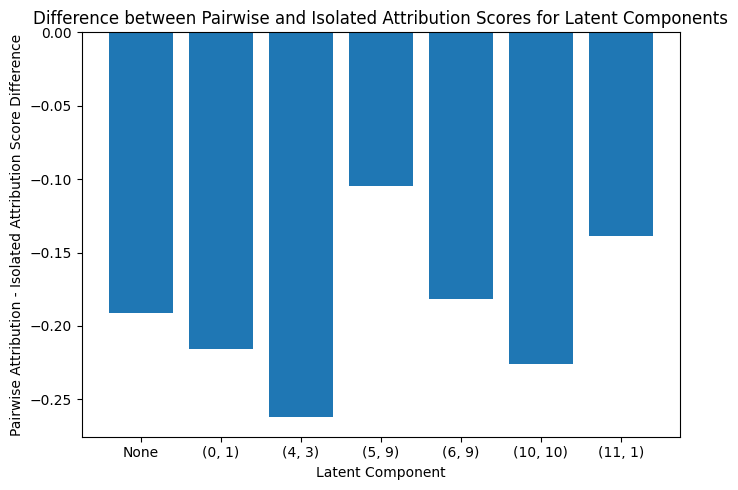

In [42]:
baseline_pairwise_isolated_diff = pairwise_isolated_ablation_diff.mean()
print(f"Baseline pairwise isolated difference: {baseline_pairwise_isolated_diff.item()}")

pairwise_isolated_ablation_diff_latent = {"None": baseline_pairwise_isolated_diff}
for sample, layer, idx in latent_attn_indices:
    diff = pairwise_isolated_ablation_diff[sample, layer, idx]
    pairwise_isolated_ablation_diff_latent[(layer.item(), idx.item())] = diff

plot_bar_chart(
    pairwise_isolated_ablation_diff_latent, 
    title="Difference between Pairwise and Isolated Attribution Scores for Latent Components", 
    ylabel="Pairwise Attribution - Isolated Attribution Score Difference", 
    xlabel="Latent Component")

## Pairwise ablation of neurons

We pick the latent component (6, 9), which has the highest difference in attribution scores, and ablate it alongside every significant component and latent component. For each ablated pair, we measure the logit difference to quantify the total effect on the model's output.

In [43]:
max_mlp_latent_indices = divmod(torch.argmax(mlp_asymmetry).item(), mlp_asymmetry.size(-1))
target_layer, target_head = max_mlp_latent_indices # (7, 3050)

print(f"Max MLP latent indices: {max_mlp_latent_indices}")
print(f"corrupt -> clean: {mlp_corrupt_clean[:, target_layer, target_head]}, clean -> corrupt: {mlp_clean_corrupt[:, target_layer, target_head]}")

Max MLP latent indices: (4, 1297)
corrupt -> clean: tensor([0.0127]), clean -> corrupt: tensor([0.0038])


In [44]:
# Reset model
device = get_device()
model = HookedTransformer.from_pretrained("gpt2-small", device=device)

# Explicitly calculate and expose the result for each attention head
model.set_use_attn_result(True)
model.set_use_hook_mlp_in(True)

Loaded pretrained model gpt2-small into HookedTransformer


In [45]:
from attribution_methods import patch_hook

# Ablate every component in the model alongside neuron (7, 3050)
mlp_pairwise_ablation = torch.zeros((model.cfg.d_mlp,))

baseline_diff = clean_logit_diff - corrupted_logit_diff

for neuron in range(model.cfg.d_mlp):
    hook_name = get_act_name("post", target_layer)

    def temp_hook(act, hook):
        act[:, :, target_head] = corrupted_cache[hook.name][:, :, target_head]
        act[:, :, neuron] = corrupted_cache[hook.name][:, :, neuron]
        return act

    with model.hooks(fwd_hooks=[(hook_name, temp_hook)]):
        patched_logits = model(clean_tokens)

    patched_logit_diff = logit_diff_metric(patched_logits, labels).detach()
    # Normalise result by clean and corrupted logit difference
    mlp_pairwise_ablation[neuron] = (patched_logit_diff - clean_logit_diff) / baseline_diff

In [46]:
torch.save(mlp_pairwise_ablation, "results/case_study/mlp_pairwise_ablation.pt")

### Analysis

In [47]:
mlp_pairwise_ablation = torch.load("results/case_study/mlp_pairwise_ablation.pt")

In [48]:
# Identify pairs of ablated components which have high scores
mlp_pairwise_ablation_important, mlp_pairwise_ablation_important_indices = highlight_components(mlp_pairwise_ablation, percentile=0.9)

# Visualise the effect on output when each component is ablated alongside (6, 9)
print(f"Number of components in layer 7 with significant effect when paired with neuron (7, 3050): {len(mlp_pairwise_ablation_important_indices)}")

Number of components in layer 7 with significant effect when paired with neuron (7, 3050): 308


In [49]:
# Measure overlap between pairwise ablation components and important components
mlp_layer_important = mlp_important[:, target_layer]
print(f"Overlap between pairwise ablation and important components: {
    measure_overlap(mlp_pairwise_ablation_important.unsqueeze(0), mlp_layer_important).item()}")

Overlap between pairwise ablation and important components: 0.3395061790943146


In [50]:
# Measure overlap between pairwise ablation components and latent components
latent_mlp_layer = latent_mlp[:, target_layer]
print(f"Overlap between pairwise ablation and latent neurons: {
    measure_overlap(mlp_pairwise_ablation_important.unsqueeze(0), latent_mlp_layer).item()}")

Overlap between pairwise ablation and latent neurons: 0.23092783987522125


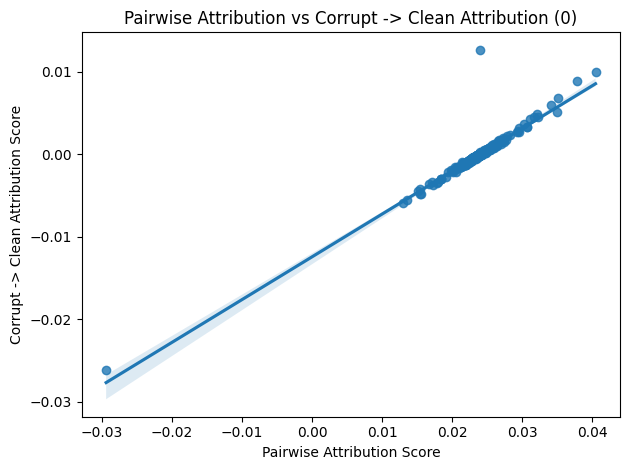

Correlation coefficient: 0.9495432503598114


In [51]:
# Check if pair of ablated neurons have high attribution scores when patching in the same direction.

plot_correlation(
    mlp_pairwise_ablation.unsqueeze(0), 
    mlp_corrupt_clean[:, target_layer], 
    "Pairwise Attribution Score", 
    "Corrupt -> Clean Attribution Score", 
    "Pairwise Attribution vs Corrupt -> Clean Attribution")

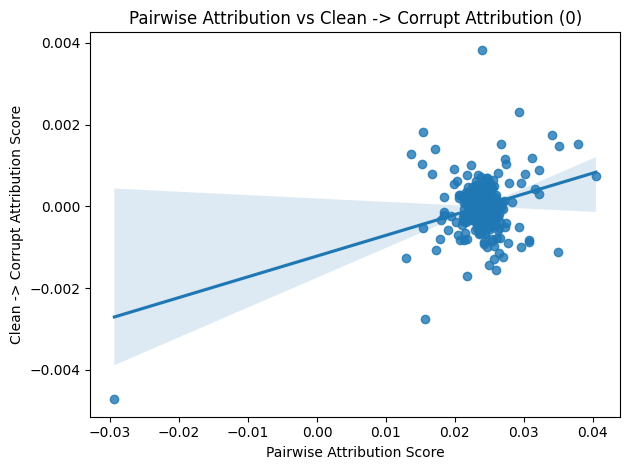

Correlation coefficient: 0.3228161792891792


In [52]:
# Check if pair of ablated neurons have high attribution scores when patching in the opposite direction.

plot_correlation(
    mlp_pairwise_ablation.unsqueeze(0), 
    mlp_clean_corrupt[:, target_layer], 
    "Pairwise Attribution Score", 
    "Clean -> Corrupt Attribution Score", 
    "Pairwise Attribution vs Clean -> Corrupt Attribution")

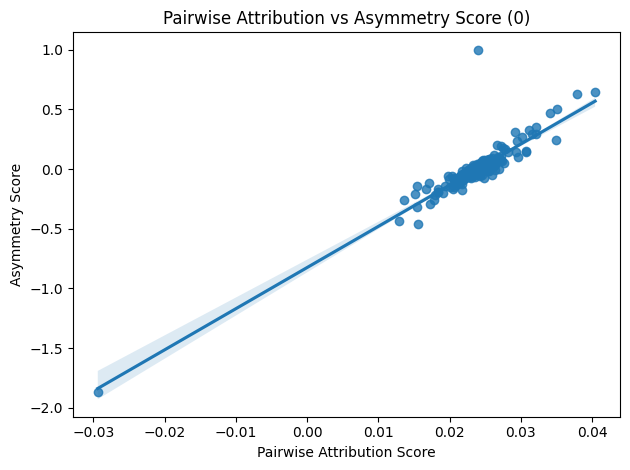

Correlation coefficient: 0.9047657978777579


In [53]:
# Compare correlation between pairwise ablation (joint components) and asymmetry scores (latent components).
plot_correlation(
    mlp_pairwise_ablation.unsqueeze(0), 
    mlp_asymmetry[:, target_layer], 
    "Pairwise Attribution Score", 
    "Asymmetry Score", 
    "Pairwise Attribution vs Asymmetry Score")

In [54]:
# Compare pairwise ablation scores with isolated ablation scores.
# Measure extra information from pairwise ablation.
pairwise_ablation_added_effect = (mlp_pairwise_ablation - mlp_corrupt_clean[0, target_layer] - mlp_clean_corrupt[0, target_layer, target_head])

Average additional effect from pairwise ablation: 0.020085088908672333


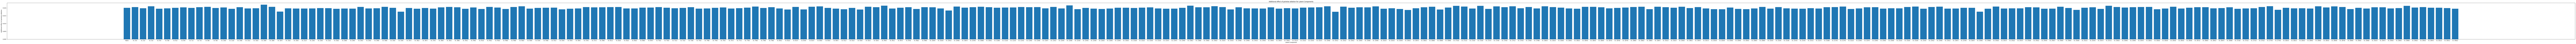

In [55]:
mean_ablation_added_effect = pairwise_ablation_added_effect.mean()
print(f"Average additional effect from pairwise ablation: {mean_ablation_added_effect.item()}")

# Proportion of latent components with significant additional pairwise effect
count_latent_high_pairwise_effect = 0
pairwise_ablation_latent_effect = {"None": mean_ablation_added_effect}
for _, layer, idx in latent_mlp_indices:
    if layer != target_layer:
        continue
    diff = pairwise_ablation_added_effect[idx]
    pairwise_ablation_latent_effect[(layer.item(), idx.item())] = diff
    if diff.abs() > mean_ablation_added_effect.abs():
        count_latent_high_pairwise_effect += 1

plot_bar_chart(
    pairwise_ablation_latent_effect, 
    title="Additional effect of pairwise ablation for Latent Components", 
    ylabel="Additional effect of pairwise ablation", 
    xlabel="Latent Component")

In [56]:
print(f"Number of components with additional effect from pairwise ablation: {pairwise_ablation_added_effect.count_nonzero().item() / len(pairwise_ablation_added_effect) * 100:.2f}%")
print(f"Number of latent components with significant additional effect from pairwise ablation: {count_latent_high_pairwise_effect / len(latent_mlp_indices) * 100:.2f}%")

Number of components with additional effect from pairwise ablation: 100.00%
Number of latent components with significant additional effect from pairwise ablation: 4.48%


In [57]:
mean_pairwise_latent_diff = torch.tensor(list(pairwise_ablation_latent_effect.values())).mean().item()
print(f"Average additional effect from pairwise ablation for latents: {mean_pairwise_latent_diff}")

Average additional effect from pairwise ablation for latents: 0.02008003368973732


### Deeper investigation with candidate partner

Latent component (7, 1442) has the highest pairwise ablation additional effect when ablated with (7, 3050).

To investigate what concrete effect this have, we ablate latent component (7, 1442) and observe the model's output.
Then we ablate latent component (7, 3050) as well, and observe the model's output.

In [106]:
# Reset model
device = get_device()
model = HookedTransformer.from_pretrained("gpt2-small", device=device)

# Explicitly calculate and expose the result for each attention head
model.set_use_attn_result(True)
model.set_use_hook_mlp_in(True)

Loaded pretrained model gpt2-small into HookedTransformer


In [138]:
model.generate(clean_input, prepend_bos=False, do_sample=False)

100%|██████████| 10/10 [00:00<00:00, 61.24it/s]


'When John and Mary went to the store, John gave a bottle of milk to Mary, and Mary gave him a bottle of milk'

In [153]:
# Original output
original_logits = model(clean_input)
original_top_token = torch.argmax(original_logits[:, -1], dim=-1)
print(f"Original top logit: {model.to_str_tokens(original_top_token)}")

Original top logit: [' Mary']


In [146]:
hook_name = get_act_name("post", 7)

def first_hook(act, hook):
    act[:, :, 3050] = corrupted_cache[hook.name][:, :, 3050]
    return act

with model.hooks(fwd_hooks=[(hook_name, first_hook)]):
    patched_logits = model(clean_tokens)
    top_token = torch.argmax(patched_logits[:, -1], dim=-1)
    print(f"Top token: {model.to_str_tokens(top_token)}")

patched_logit_diff = logit_diff_metric(patched_logits, labels).detach()
# # Normalise result by clean and corrupted logit difference
patched_score = (patched_logit_diff - clean_logit_diff) / baseline_diff
print(f"Patched logit difference: {patched_score.item()}")

Top token: [' Mary']
Patched logit difference: 7.599747657775879


In [147]:
def second_hook(act, hook):
    act[:, :, 3050] = corrupted_cache[hook.name][:, :, 3050]
    act[:, :, 1442] = corrupted_cache[hook.name][:, :, 1442]
    return act

with model.hooks(fwd_hooks=[(hook_name, second_hook)]):
    pairwise_logits = model(clean_tokens)
    pairwise_top_token = torch.argmax(pairwise_logits[:, -1], dim=-1)
    print(f"Pairwise top token: {model.to_str_tokens(pairwise_top_token)}")

pairwise_logit_diff = logit_diff_metric(pairwise_logits, labels).detach()
# # Normalise result by clean and corrupted logit difference
pairwise_score = (pairwise_logit_diff - clean_logit_diff) / baseline_diff
print(f"Pairwise logit difference: {pairwise_score.item()}")

Pairwise top token: [' Mary']
Pairwise logit difference: 7.994039058685303


In [156]:
# Ablate a random neuron which is not a latent component
def third_hook(act, hook):
    act[:, :, 3050] = corrupted_cache[hook.name][:, :, 3050]
    act[:, :, 5] = corrupted_cache[hook.name][:, :, 5]
    return act

with model.hooks(fwd_hooks=[(hook_name, third_hook)]):
    pairwise_logits = model(clean_tokens)
    pairwise_top_token = torch.argmax(pairwise_logits[:, -1], dim=-1)
    print(f"Pairwise top token: {model.to_str_tokens(pairwise_top_token)}")

pairwise_logit_diff = logit_diff_metric(pairwise_logits, labels).detach()
# # Normalise result by clean and corrupted logit difference
pairwise_score = (pairwise_logit_diff - clean_logit_diff) / baseline_diff
print(f"Random pairwise logit difference: {pairwise_score.item()}")

Pairwise top token: [' Mary']
Random pairwise logit difference: 7.576426029205322


Ablating two specific latent components together yields higher change in logits compared to ablating just (7, 3050) or ablating (7, 3050) with a random non-latent component.

## Scaling up: pairwise ablation of neurons

### Experiment

In [58]:
# Reset model
device = get_device()
model = HookedTransformer.from_pretrained("gpt2-small", device=device)

# Explicitly calculate and expose the result for each attention head
model.set_use_attn_result(True)
model.set_use_hook_mlp_in(True)

Loaded pretrained model gpt2-small into HookedTransformer


In [59]:
max_mlp_latent_indices = torch.argmax(mlp_asymmetry, dim=-1)[0]
max_mlp_latent_indices = [(i, max_mlp_latent_indices[i].item()) for i in range(model.cfg.n_layers)]
print(f"Max MLP latent indices: {max_mlp_latent_indices}")

Max MLP latent indices: [(0, 1579), (1, 2328), (2, 1683), (3, 176), (4, 1297), (5, 881), (6, 1252), (7, 2367), (8, 1332), (9, 1003), (10, 1690), (11, 2870)]


In [ ]:
# Ablate every component in the model alongside the latent component with highest asymmetry score in each layer
mlp_pairwise_ablation = torch.zeros((model.cfg.n_layers, model.cfg.d_mlp))
baseline_diff = clean_logit_diff - corrupted_logit_diff

for target_layer, target_idx in max_mlp_latent_indices:
    print(f"Ablating layer {target_layer}, neuron {target_idx}")
    hook_name = get_act_name("post", target_layer)

    for neuron in range(model.cfg.d_mlp):

        def temp_hook(act, hook):
            act[:, :, target_idx] = corrupted_cache[hook.name][:, :, target_idx]
            act[:, :, neuron] = corrupted_cache[hook.name][:, :, neuron]
            return act

        with model.hooks(fwd_hooks=[(hook_name, temp_hook)]):
            patched_logits = model(clean_tokens)

        patched_logit_diff = logit_diff_metric(patched_logits, labels).detach()
        # Normalise result by clean and corrupted logit difference
        mlp_pairwise_ablation[target_layer, neuron] = (patched_logit_diff - clean_logit_diff) / baseline_diff

Ablating layer 0, neuron 1579


In [ ]:
torch.save(mlp_pairwise_ablation, "results/case_study/scaled_mlp_pairwise_ablation.pt")

### Analysis

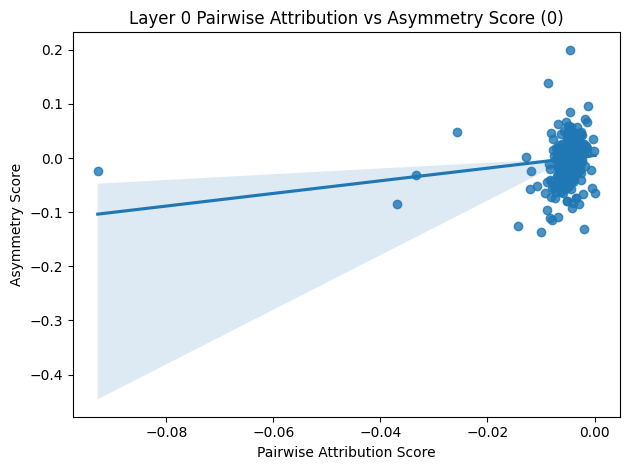

Correlation coefficient: 0.16946994589498113


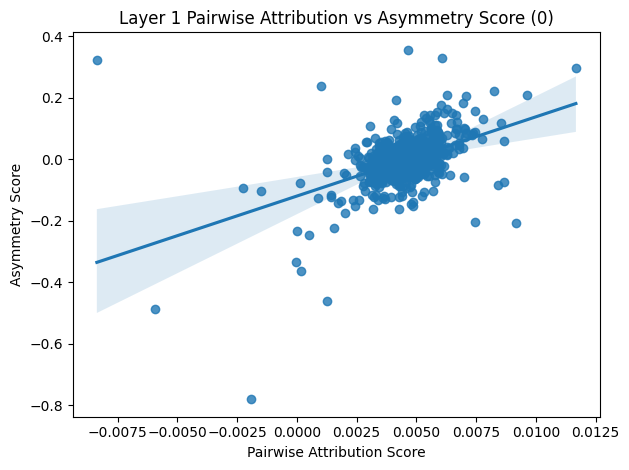

Correlation coefficient: 0.46366953365404184


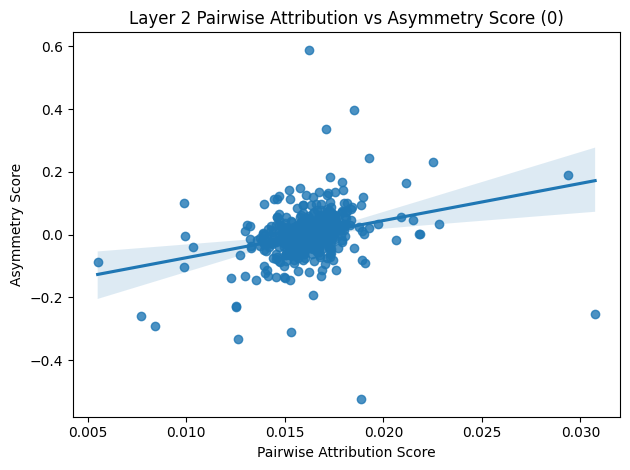

Correlation coefficient: 0.2902345125933933


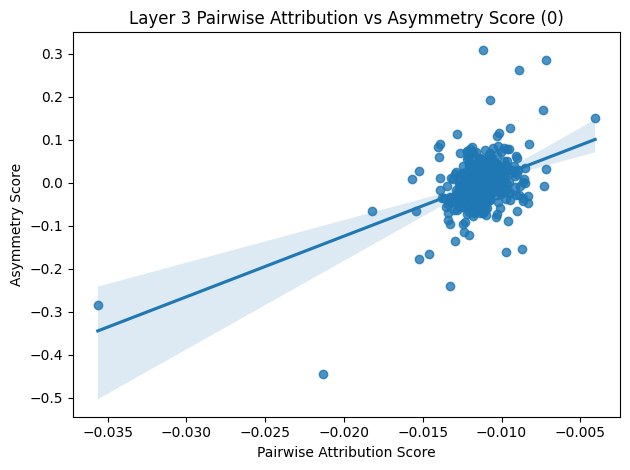

Correlation coefficient: 0.444187081272367


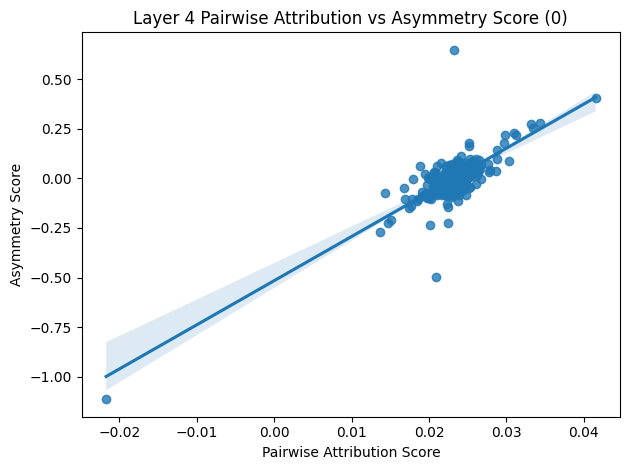

Correlation coefficient: 0.7712828388974518


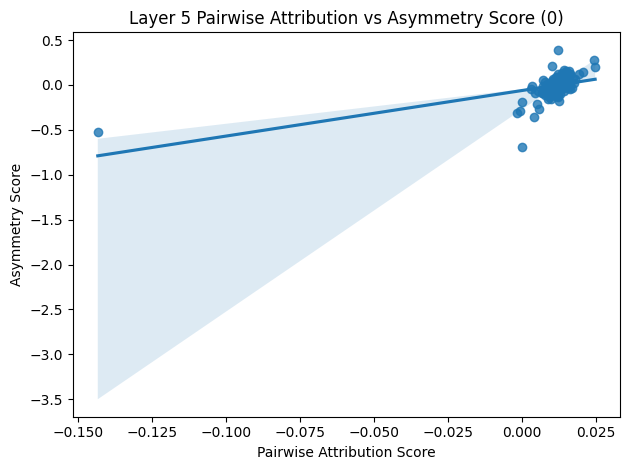

Correlation coefficient: 0.5038688771964817


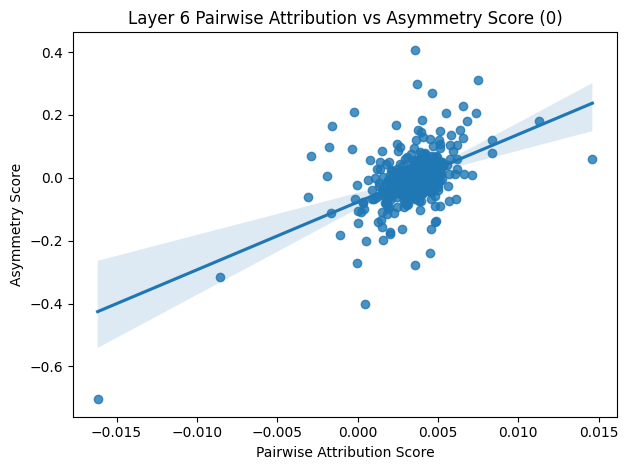

Correlation coefficient: 0.5109652225607644


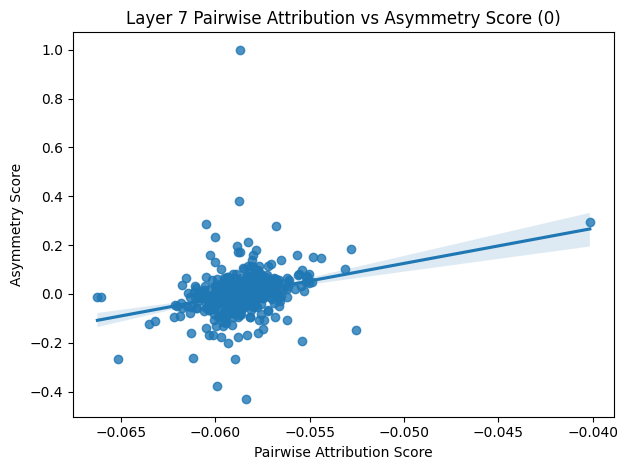

Correlation coefficient: 0.28796525044764887


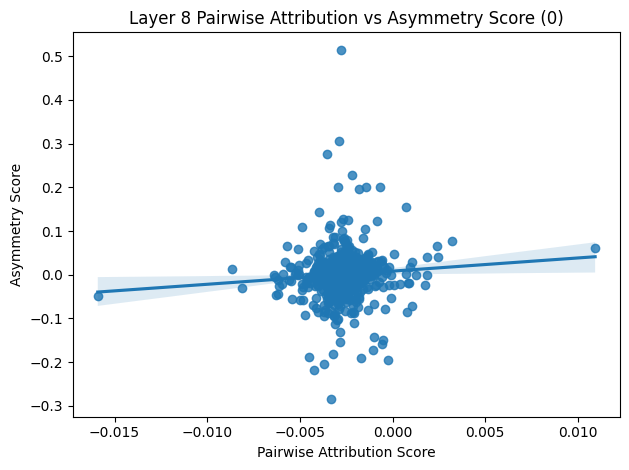

Correlation coefficient: 0.07957900446622203


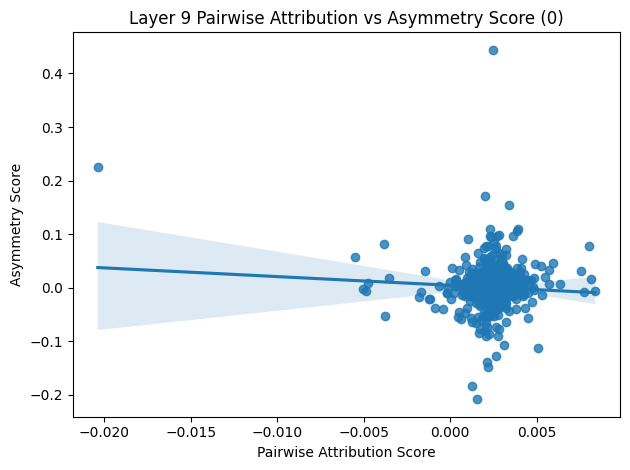

Correlation coefficient: -0.06529949564582033


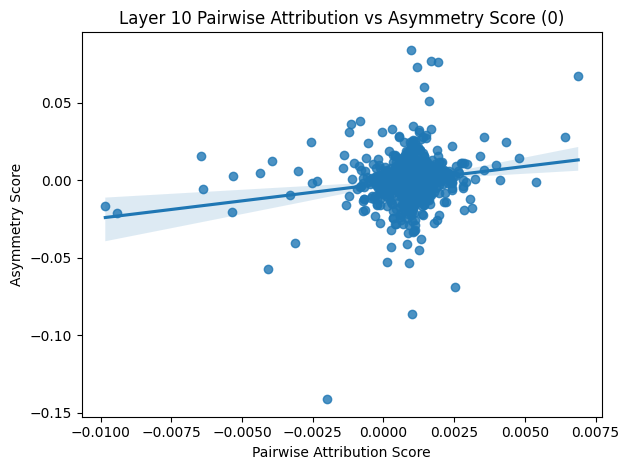

Correlation coefficient: 0.17222667648413856


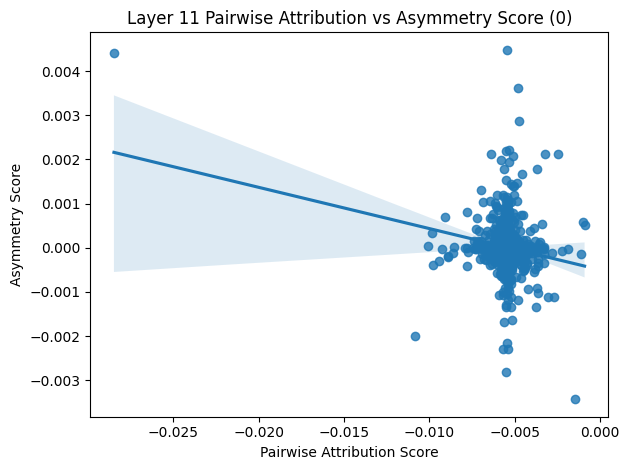

Correlation coefficient: -0.19373657311545006


In [ ]:
for layer in range(model.cfg.n_layers):
    plot_correlation(
        mlp_pairwise_ablation[layer].unsqueeze(0), 
        mlp_asymmetry[:, layer], 
        "Pairwise Attribution Score", 
        "Asymmetry Score", 
        f"Layer {layer} Pairwise Attribution vs Asymmetry Score")